In [1]:
import mujoco
import numpy as np
import mediapy as media


Load the xml file as a Mujoco Sim

Add a viewer window to visualise

""

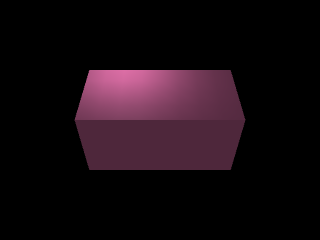

In [2]:
xml = """
<mujoco>
    <option collision="predefined" />
    <option timestep="0.00005" />
    <default>
        <geom rgba=".8 .4 .6 1" />
    </default>
    <worldbody>
    <light name="top" pos="0 1 5"/>
	<geom name="floor" pos="0 0 -0.5" size="1 1 0.125" type="plane" condim="3" rgba="1 1 1 1" />
	<body name="root" pos="0 0 0">
	    <geom type="box" size="1 1 1" mass="1"/>
	    <body name="b1" pos="2 0 0">
		<geom type="box" size="1 1 1" mass="1"/>
		<joint name="j1" type="hinge" pos="-1 0 0" axis ="0 1 0"/>
	    </body>
	</body>
    </worldbody>
    <actuator>
        <position ctrllimited = "true" ctrlrange="-1 1" kp="200" joint="j1" name="a1" />
        <velocity ctrllimited = "true" ctrlrange="-1 1" kv="30" joint="j1" name="a2" />
    </actuator>
</mujoco>"""

model = mujoco.MjModel.from_xml_string(xml)
                     # from_xml_path(file_path) is also an option
data = mujoco.MjData(model)

renderer = mujoco.Renderer(model)
mujoco.mj_forward(model,data)
renderer.update_scene(data)
media.show_image(renderer.render())

Now lets control the joint

In [3]:
max_time = 10.0
framerate = 60
x = np.arange(0.0, max_time+0.00005, 0.00005)
y = np.sin(10*x)

frames = []
mujoco.mj_resetData(model,data)
count = 0
while data.time < max_time :
    data.ctrl[1] = y[count]
    count = count + 1;
    #data.ctrl[1] = np.cos(data.time)
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render().copy()
        frames.append(pixels)
        
media.show_video(frames, fps=framerate)

Now lets add an sns

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sns_toolbox.neurons import NonSpikingNeuron, NonSpikingNeuronWithGatedChannels, NonSpikingNeuronWithPersistentSodiumChannel
from sns_toolbox.connections import NonSpikingSynapse
from sns_toolbox.networks import Network
from sns_toolbox.renderer import render

import numpy as np
import matplotlib.pyplot as plt

In [5]:
def zinf(U, Kz, Sz, Ez):
    return 1/(1+Kz*np.exp(Sz*(Ez-U)))

def tauz(U, tauzmax, Kz, Sz, Ez):
    return tauzmax*zinf(U, Kz, Sz, Ez)*np.sqrt(Kz*np.exp(Sz*(Ez-U)))

In [6]:
def minf(U):
    return zinf(U, Km, S, delEm)

def hinf(U):
    return zinf(U, Kh, -S, delEh)

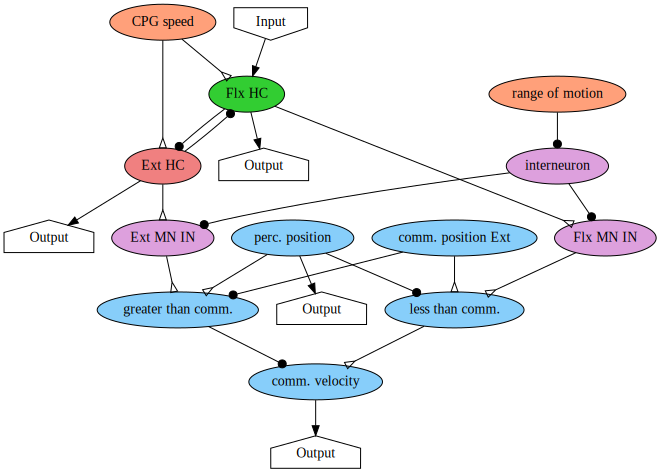

In [7]:
delta = 0.05
Cm = 5
Gm = 1
Ena = 50
Er = -60
R = 20

S = 0.05
delEna = Ena - Er
Km = 1
Kh = 0.5
Em = -40
Eh = -60
delEm = Em-Er
delEh = Eh-Er
tauHmax = 300

Gna = Gm*R/(zinf(R, Km, S, delEm)*zinf(R, Kh, -S, delEh)*(delEna-R))

g_ion = [Gna]
e_ion = [delEna]

pow_m = [1]
k_m = [Km]
slope_m = [S]
e_m = [delEm]

pow_h = [1]
k_h = [Kh]
slope_h = [-S]
e_h = [delEh]
tau_max_h = [tauHmax]

neuron_cpg = NonSpikingNeuronWithPersistentSodiumChannel(membrane_capacitance=Cm, membrane_conductance=Gm,
                                                             g_ion=g_ion,e_ion=e_ion,
                                                             k_m=k_m,slope_m=slope_m,e_m=e_m,
                                                             k_h=k_h,slope_h=slope_h,e_h=e_h,tau_max_h=tau_max_h,
                                                             name='HC',color='orange')
non_spiking_neuron_vel = NonSpikingNeuron(membrane_capacitance=5.0,membrane_conductance=1.0, resting_potential=10)
non_spiking_neuron_base = NonSpikingNeuron(membrane_capacitance=5.0,membrane_conductance=1.0, resting_potential=0)
non_spiking_neuron_IN = NonSpikingNeuron(membrane_capacitance=5.0,membrane_conductance=1.0, resting_potential=0, bias = 0)
non_spiking_neuron_range = NonSpikingNeuron(membrane_capacitance=5.0,membrane_conductance=1.0, resting_potential=0, bias = 2)
non_spiking_neuron_speed = NonSpikingNeuron(membrane_capacitance=5.0,membrane_conductance=1.0, resting_potential=0, bias = 0.1)

hyp_ipsp_cpg = NonSpikingSynapse(max_conductance=1.625,reversal_potential=-10,e_lo = 0,e_hi = 40)
dep_epsp_cpg = NonSpikingSynapse(max_conductance=1.625,reversal_potential= 100,e_lo = 0,e_hi = 40)
dep_add = NonSpikingSynapse(max_conductance=0.1,reversal_potential=160,e_lo = 0,e_hi = 20)
hyp_mult = NonSpikingSynapse(max_conductance=0.5,reversal_potential=-40,e_lo = 0,e_hi = 20)
hyp_sub = NonSpikingSynapse(max_conductance=0.55,reversal_potential=-40,e_lo = 0,e_hi = 20)


Ein = -100
delEsyn = Ein-R

gSyn = (-delta - delta*Gna*minf(delta)*hinf(delta) + Gna*minf(delta)*hinf(delta)*delEna)/(delta - delEsyn)

synapse_cpg = NonSpikingSynapse(max_conductance=gSyn, reversal_potential=delEsyn)

net = Network()
# CPG
net.add_neuron(non_spiking_neuron_speed, name='CPG speed',color='lightsalmon')
net.add_neuron(neuron_cpg,name='Flx HC',color='limegreen')
net.add_neuron(neuron_cpg,name='Ext HC',color='lightcoral')

# Command network
net.add_neuron(non_spiking_neuron_base, name='greater than comm.',color='lightskyblue')
net.add_neuron(non_spiking_neuron_base, name='less than comm.',color='lightskyblue')
net.add_neuron(non_spiking_neuron_vel, name='comm. velocity',color='lightskyblue')
net.add_neuron(non_spiking_neuron_vel, name='comm. position Ext',color='lightskyblue')
net.add_neuron(non_spiking_neuron_vel, name='perc. position',color='lightskyblue')

# intermediate
net.add_neuron(non_spiking_neuron_range, name='range of motion',color='lightsalmon')
net.add_neuron(non_spiking_neuron_IN, name='interneuron',color='plum')
net.add_neuron(non_spiking_neuron_base, name='Ext MN IN',color='plum')
net.add_neuron(non_spiking_neuron_base, name='Flx MN IN',color='plum')

# Connections
net.add_connection(dep_add, 'CPG speed','Flx HC')
net.add_connection(dep_add, 'CPG speed','Ext HC')
net.add_connection(synapse_cpg,'Flx HC','Ext HC')
net.add_connection(synapse_cpg,'Ext HC','Flx HC')

net.add_connection(dep_add, 'Ext HC','Ext MN IN')
net.add_connection(dep_add, 'Flx HC','Flx MN IN')
net.add_connection(hyp_mult, 'range of motion','interneuron')
net.add_connection(hyp_mult,'interneuron','Ext MN IN')
net.add_connection(hyp_mult,'interneuron','Flx MN IN')

net.add_connection(hyp_sub, 'greater than comm.','comm. velocity')
net.add_connection(dep_add, 'less than comm.','comm. velocity')
net.add_connection(dep_add, 'Flx MN IN','less than comm.')
net.add_connection(dep_add, 'comm. position Ext','less than comm.')
net.add_connection(hyp_sub, 'perc. position','less than comm.')
net.add_connection(hyp_sub, 'comm. position Ext','greater than comm.')
net.add_connection(dep_add, 'perc. position','greater than comm.')
net.add_connection(dep_add, 'Ext MN IN','greater than comm.')

# Inputs and Outputs
net.add_input('Flx HC')
net.add_output('Flx HC')
net.add_output('Ext HC')
net.add_output('comm. velocity')
net.add_output('perc. position')


I = 0
tStart = 1000
tEnd = 4000
tTail = 2500

dt = 0.05
tMax = 5000
t = np.arange(0,tMax,dt)
numSteps = np.size(t)

Iapp = np.zeros(numSteps)
Iapp[tStart:tEnd] = I
Ipert = np.zeros(numSteps)
Ipert[1] = 1

#data = np.zeros([len(t), net.get_num_outputs_actual()])
inputs = Iapp + Ipert
render(net)

In [8]:
def sns2mujoco(comm_vel):
    #maps the comm. velocity neural potential to a -1 to 1 motor activation
    # 0 - 20 mV to -1 1 with a linear function
    output = 0.1*comm_vel - 1
    
    return output


# make linear
   
    

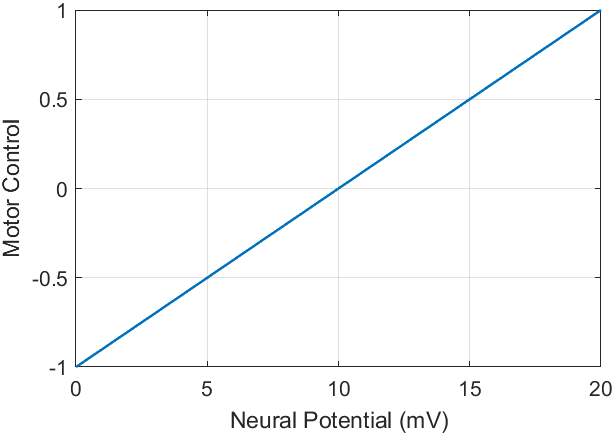



In [9]:
max_time = 10.0
framerate = 60

frames = []
mujoco.mj_resetData(model,data)
count = 0

sns_model = net.compile(backend='numpy', dt = dt)
sns_data = np.zeros([numSteps,4])
joint_angle = np.zeros(numSteps)

for i in range(0,len(t)):
    sns_data[i,:] = sns_model([inputs[i-1]])
    data.ctrl[1] = sns2mujoco(sns_data[i-1,2])
    count = count + 1;
    mujoco.mj_step(model, data)
    joint_angle[i] = data.qpos[0]
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render().copy()
        frames.append(pixels)
        
media.show_video(frames, fps=framerate)

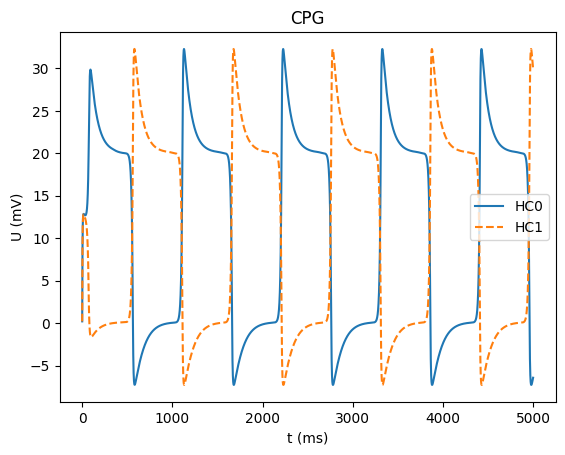

In [10]:
sns_data = sns_data.transpose() 
plt.plot(t,sns_data[:][0],label='HC0',color='C0')
plt.plot(t,sns_data[:][1],label='HC1',color='C1',linestyle='--')
plt.xlabel('t (ms)')
plt.ylabel('U (mV)')
plt.title('CPG')
plt.legend()

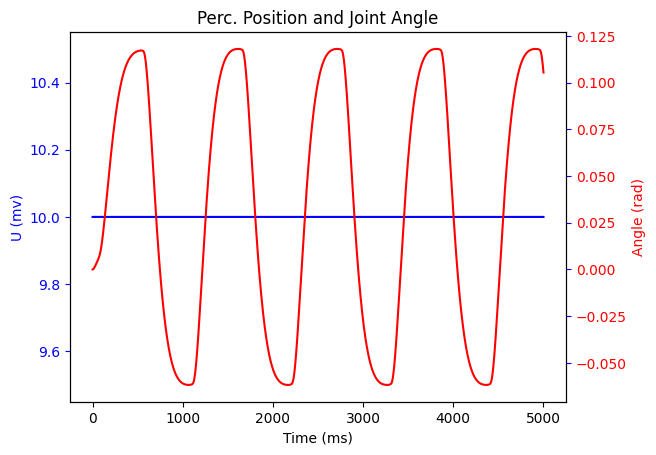

In [11]:
fig,ax1 = plt.subplots()

ax1.plot(t,sns_data[:][3],color='blue',linestyle='-')
ax1.set_ylabel('U (mv)', color='blue')
ax1.tick_params(axis='y', color='blue', labelcolor='blue')
ax1.set_xlabel('Time (ms)')

ax1.set_title('Perc. Position and Joint Angle')

ax2 = ax1.twinx()
ax2.plot(t,joint_angle,color='red',linestyle='-')
ax2.set_ylabel('Angle (rad)', color='red')
ax2.tick_params(axis='y', color='blue', labelcolor='red')



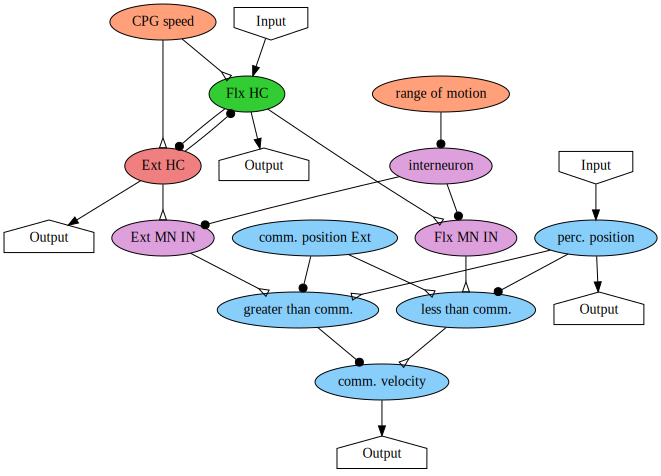

In [12]:
delta = 0.05
Cm = 5
Gm = 1
Ena = 50
Er = -60
R = 20

S = 0.05
delEna = Ena - Er
Km = 1
Kh = 0.5
Em = -40
Eh = -60
delEm = Em-Er
delEh = Eh-Er
tauHmax = 300

Gna = Gm*R/(zinf(R, Km, S, delEm)*zinf(R, Kh, -S, delEh)*(delEna-R))

g_ion = [Gna]
e_ion = [delEna]

pow_m = [1]
k_m = [Km]
slope_m = [S]
e_m = [delEm]

pow_h = [1]
k_h = [Kh]
slope_h = [-S]
e_h = [delEh]
tau_max_h = [tauHmax]

neuron_cpg = NonSpikingNeuronWithPersistentSodiumChannel(membrane_capacitance=Cm, membrane_conductance=Gm,
                                                             g_ion=g_ion,e_ion=e_ion,
                                                             k_m=k_m,slope_m=slope_m,e_m=e_m,
                                                             k_h=k_h,slope_h=slope_h,e_h=e_h,tau_max_h=tau_max_h,
                                                             name='HC',color='orange')
non_spiking_neuron_vel = NonSpikingNeuron(membrane_capacitance=5.0,membrane_conductance=1.0, resting_potential=10)
non_spiking_neuron_base = NonSpikingNeuron(membrane_capacitance=5.0,membrane_conductance=1.0, resting_potential=0)
non_spiking_neuron_IN = NonSpikingNeuron(membrane_capacitance=5.0,membrane_conductance=1.0, resting_potential=0, bias = 0)
non_spiking_neuron_range = NonSpikingNeuron(membrane_capacitance=5.0,membrane_conductance=1.0, resting_potential=0, bias = 2)
non_spiking_neuron_speed = NonSpikingNeuron(membrane_capacitance=5.0,membrane_conductance=1.0, resting_potential=0, bias = 1.0)

hyp_ipsp_cpg = NonSpikingSynapse(max_conductance=1.625,reversal_potential=-10,e_lo = 0,e_hi = 40)
dep_epsp_cpg = NonSpikingSynapse(max_conductance=1.625,reversal_potential= 100,e_lo = 0,e_hi = 40)
dep_add = NonSpikingSynapse(max_conductance=0.1,reversal_potential=160,e_lo = 0,e_hi = 20)
hyp_mult = NonSpikingSynapse(max_conductance=0.5,reversal_potential=-40,e_lo = 0,e_hi = 20)
hyp_sub = NonSpikingSynapse(max_conductance=0.55,reversal_potential=-40,e_lo = 0,e_hi = 20)


Ein = -100
delEsyn = Ein-R

gSyn = (-delta - delta*Gna*minf(delta)*hinf(delta) + Gna*minf(delta)*hinf(delta)*delEna)/(delta - delEsyn)

synapse_cpg = NonSpikingSynapse(max_conductance=gSyn, reversal_potential=delEsyn)

net = Network()
# CPG
net.add_neuron(non_spiking_neuron_speed, name='CPG speed',color='lightsalmon')
net.add_neuron(neuron_cpg,name='Flx HC',color='limegreen')
net.add_neuron(neuron_cpg,name='Ext HC',color='lightcoral')

# Command network
net.add_neuron(non_spiking_neuron_base, name='greater than comm.',color='lightskyblue')
net.add_neuron(non_spiking_neuron_base, name='less than comm.',color='lightskyblue')
net.add_neuron(non_spiking_neuron_vel, name='comm. velocity',color='lightskyblue')
net.add_neuron(non_spiking_neuron_vel, name='comm. position Ext',color='lightskyblue')
net.add_neuron(non_spiking_neuron_vel, name='perc. position',color='lightskyblue')

# intermediate
net.add_neuron(non_spiking_neuron_range, name='range of motion',color='lightsalmon')
net.add_neuron(non_spiking_neuron_IN, name='interneuron',color='plum')
net.add_neuron(non_spiking_neuron_base, name='Ext MN IN',color='plum')
net.add_neuron(non_spiking_neuron_base, name='Flx MN IN',color='plum')

# Connections
net.add_connection(dep_add, 'CPG speed','Flx HC')
net.add_connection(dep_add, 'CPG speed','Ext HC')
net.add_connection(synapse_cpg,'Flx HC','Ext HC')
net.add_connection(synapse_cpg,'Ext HC','Flx HC')

net.add_connection(dep_add, 'Ext HC','Ext MN IN')
net.add_connection(dep_add, 'Flx HC','Flx MN IN')
net.add_connection(hyp_mult, 'range of motion','interneuron')
net.add_connection(hyp_mult,'interneuron','Ext MN IN')
net.add_connection(hyp_mult,'interneuron','Flx MN IN')

net.add_connection(hyp_sub, 'greater than comm.','comm. velocity')
net.add_connection(dep_add, 'less than comm.','comm. velocity')
net.add_connection(dep_add, 'Flx MN IN','less than comm.')
net.add_connection(dep_add, 'comm. position Ext','less than comm.')
net.add_connection(hyp_sub, 'perc. position','less than comm.')
net.add_connection(hyp_sub, 'comm. position Ext','greater than comm.')
net.add_connection(dep_add, 'perc. position','greater than comm.')
net.add_connection(dep_add, 'Ext MN IN','greater than comm.')

# Inputs and Outputs
net.add_input('Flx HC')
net.add_input('perc. position')
net.add_output('Flx HC')
net.add_output('Ext HC')
net.add_output('perc. position')
net.add_output('comm. velocity')




I = 0
tStart = 1000
tEnd = 4000
tTail = 2500

dt = 0.05
tMax = 5000
t = np.arange(0,tMax,dt)
numSteps = np.size(t)

Iapp = np.zeros([numSteps,2])
Iapp[tStart:tEnd] = I
Ipert = np.zeros([numSteps,2])
Ipert[0,0] = 1

#data = np.zeros([len(t), net.get_num_outputs_actual()])
inputs = Iapp + Ipert
render(net)

In [13]:
# add feedback (linear function - inverse of command)
def mujoco2sns(joint_pos):
    #maps the comm. velocity neural potential to a -1 to 1 motor activation
    # 0 - 20 mV to -1 1 with a linear function
    feedback = 10*(10*joint_pos-1)
    
    return feedback

In [14]:
max_time = 10.0
framerate = 60

frames = []
mujoco.mj_resetData(model,data)
count = 0

sns_model = net.compile(backend='numpy', dt = dt)
sns_data = np.zeros([numSteps,4])
joint_angle = np.zeros(numSteps)
sns_input = [1,0]

for i in range(0,len(t)):
    sns_data[i,:] = sns_model(sns_input)
    data.ctrl[1] = sns2mujoco(sns_data[i-1,3])
    count = count + 1;
    mujoco.mj_step(model, data)
    joint_angle[i] = data.qpos[0]
    sns_input = [0,mujoco2sns(data.qpos[0])]
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render().copy()
        frames.append(pixels)
        
media.show_video(frames, fps=framerate)

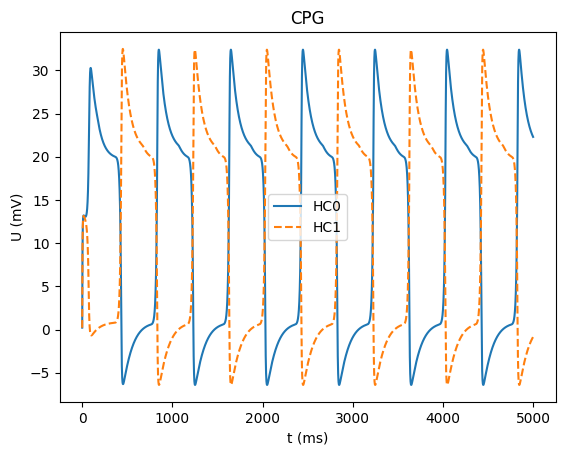

In [15]:
sns_data = sns_data.transpose() 
plt.plot(t,sns_data[:][0],label='HC0',color='C0')
plt.plot(t,sns_data[:][1],label='HC1',color='C1',linestyle='--')
plt.xlabel('t (ms)')
plt.ylabel('U (mV)')
plt.title('CPG')
plt.legend()

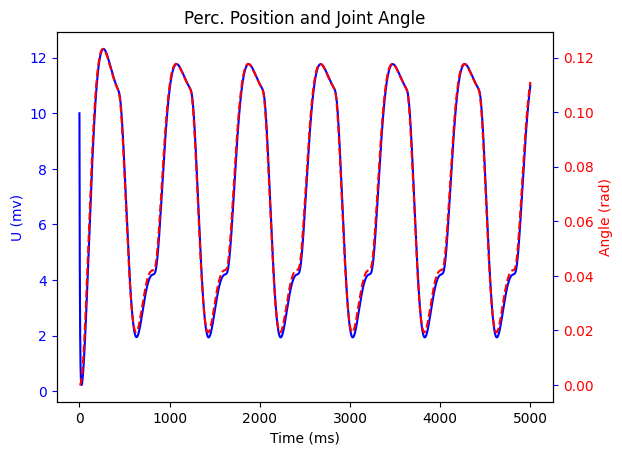

In [16]:
fig,ax1 = plt.subplots()

ax1.plot(t,sns_data[:][2],color='blue',linestyle='-')
ax1.set_ylabel('U (mv)', color='blue')
ax1.tick_params(axis='y', color='blue', labelcolor='blue')
ax1.set_xlabel('Time (ms)')

ax1.set_title('Perc. Position and Joint Angle')

ax2 = ax1.twinx()
ax2.plot(t,joint_angle,color='red',linestyle='--')
ax2.set_ylabel('Angle (rad)', color='red')
ax2.tick_params(axis='y', color='blue', labelcolor='red')

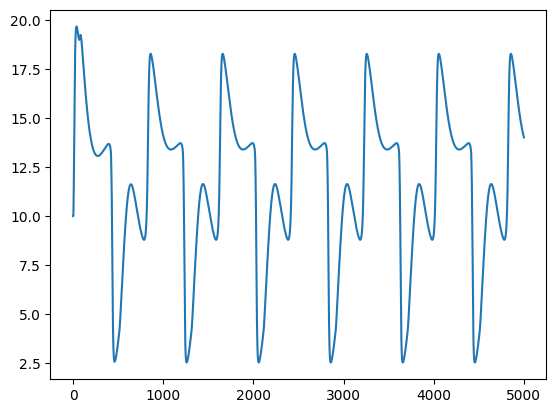

In [17]:
plt.plot(t,sns_data[:][3],label='HC0',color='C0')